In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.display import display

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
import random
from sklearn.model_selection import KFold

In [5]:
from tqdm.auto import tqdm

In [6]:
datos = pd.read_csv('../data/bank-full.csv', sep=';')
datos.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
variables = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
    'y'
]


In [8]:
df = datos[variables]

In [9]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [11]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [12]:
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   balance    45211 non-null  int64 
 5   housing    45211 non-null  object
 6   contact    45211 non-null  object
 7   day        45211 non-null  int64 
 8   month      45211 non-null  object
 9   duration   45211 non-null  int64 
 10  campaign   45211 non-null  int64 
 11  pdays      45211 non-null  int64 
 12  previous   45211 non-null  int64 
 13  poutcome   45211 non-null  object
 14  y          45211 non-null  object
dtypes: int64(7), object(8)
memory usage: 5.2+ MB


In [14]:
categorical = [col for col in df.select_dtypes(include=['object']).columns if col != 'y']
categorical

['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [15]:
numerical = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
numerical

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* balance
* day
* duration
* previous

In [16]:
def calculate_auc(feature, target):
    auc = roc_auc_score(target, feature)
    if auc < 0.5:
        auc = roc_auc_score(target, -feature)
    return auc

In [17]:
auc_scores = {}

for col in numerical:
    auc = calculate_auc(df_train[col], df_train['y'])
    auc_scores[col] = auc

In [18]:
auc_scores

{'age': 0.512185717527344,
 'balance': 0.5888313805382317,
 'day': 0.525957882383908,
 'duration': 0.8147002759670778,
 'campaign': 0.5714543015682159,
 'pdays': 0.5901276247352144,
 'previous': 0.5985653242764153}

In [19]:
variables_of_interest = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
highest_auc = max(variables_of_interest, key=lambda x: auc_scores[x])
print(f"La variable con el AUC más alto es: {highest_auc}")
print("AUC Scores:")
for var in variables_of_interest:
    print(f"{var}: {auc_scores[var]:.4f}")

La variable con el AUC más alto es: duration
AUC Scores:
age: 0.5122
balance: 0.5888
day: 0.5260
duration: 0.8147
campaign: 0.5715
pdays: 0.5901
previous: 0.5986


# Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.69
* 0.79
* 0.89
* 0.99

In [20]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

'''del df_train['y']
del df_val['y']
del df_test['y']'''

"del df_train['y']\ndel df_val['y']\ndel df_test['y']"

In [21]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000, solver='liblinear')
    model.fit(X_train, y_train)
    
    return dv, model

In [22]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [23]:
dv, model = train(df_train, y_train, C=1.0)

In [24]:
y_pred = predict(df_val, dv, model)

In [25]:
auc = roc_auc_score(y_val, y_pred)
print(f"ACU: {auc}")

ACU: 0.9004143531129565


# Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

In [27]:
y_val = (y_val == 'yes').astype(int)
y_val

array([0, 0, 0, ..., 0, 0, 0])

In [28]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [29]:
thresholds = np.linspace(0.0, 1.0, 101)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [30]:
round = 4
scores = []

for t in thresholds:
    predict_positive = (y_pred >= t)
    
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    
    fn = (predict_negative & actual_positive).sum()
    
    precision = (tp / (tp +fp)).round(round)
    
    recall = (tp / (tp + fn)).round(round)
    
    scores.append((t, precision, recall))
    



In [31]:
scores

[(0.0, 0.1214, 1.0),
 (0.01, 0.1351, 0.9964),
 (0.02, 0.1588, 0.9954),
 (0.03, 0.1865, 0.99),
 (0.04, 0.2194, 0.9727),
 (0.05, 0.2544, 0.9545),
 (0.06, 0.289, 0.929),
 (0.07, 0.3168, 0.9044),
 (0.08, 0.3426, 0.8825),
 (0.09, 0.3667, 0.8607),
 (0.1, 0.3831, 0.8443),
 (0.11, 0.3984, 0.8179),
 (0.12, 0.4146, 0.7851),
 (0.13, 0.4283, 0.7614),
 (0.14, 0.4407, 0.7441),
 (0.15, 0.4503, 0.7268),
 (0.16, 0.4663, 0.7113),
 (0.17, 0.4757, 0.6949),
 (0.18, 0.4885, 0.6785),
 (0.19, 0.4993, 0.6621),
 (0.2, 0.5071, 0.6485),
 (0.21, 0.5159, 0.6339),
 (0.22, 0.5289, 0.6248),
 (0.23, 0.5379, 0.6075),
 (0.24, 0.5409, 0.5902),
 (0.25, 0.5522, 0.5783),
 (0.26, 0.5562, 0.5638),
 (0.27, 0.5626, 0.5483),
 (0.28, 0.5691, 0.5401),
 (0.29, 0.5713, 0.5255),
 (0.3, 0.5801, 0.5146),
 (0.31, 0.5846, 0.5036),
 (0.32, 0.5928, 0.4973),
 (0.33, 0.596, 0.4836),
 (0.34, 0.5998, 0.4736),
 (0.35000000000000003, 0.6036, 0.4645),
 (0.36, 0.6095, 0.4563),
 (0.37, 0.6165, 0.4481),
 (0.38, 0.6165, 0.4362),
 (0.39, 0.6209, 0.4281

In [32]:
columns = ['t', 'Precision', 'Recall']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,t,Precision,Recall
0,0.00,0.1214,1.0000
1,0.01,0.1351,0.9964
2,0.02,0.1588,0.9954
3,0.03,0.1865,0.9900
4,0.04,0.2194,0.9727
...,...,...,...
96,0.96,0.6383,0.0273
97,0.97,0.6250,0.0228
98,0.98,0.6774,0.0191
99,0.99,0.6875,0.0100


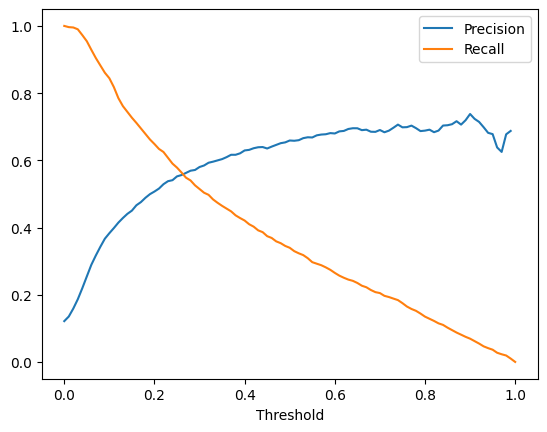

In [33]:
plt.plot(df_scores.t, df_scores.Precision, label='Precision')
plt.plot(df_scores.t, df_scores.Recall, label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()

In [34]:
df_scores

,t,Precision,Recall
0,0.00,0.1214,1.0000
1,0.01,0.1351,0.9964
2,0.02,0.1588,0.9954
3,0.03,0.1865,0.9900
4,0.04,0.2194,0.9727
...,...,...,...
96,0.96,0.6383,0.0273
97,0.97,0.6250,0.0228
98,0.98,0.6774,0.0191
99,0.99,0.6875,0.0100


In [35]:
# Calcular la diferencia entre a y b
diff = df_scores['Precision'] - df_scores['Recall']

# Encontrar los índices donde el signo cambia (es decir, el punto de intersección)
sign_change = np.where(np.diff(np.sign(diff)))[0]

# Si hay intersección, se puede encontrar el valor de t donde ocurre
if len(sign_change) > 0:
    # Interpolación lineal para obtener un valor más preciso de t
    idx = sign_change[0]
    t1, t2 = df_scores['t'].iloc[idx], df_scores['t'].iloc[idx + 1]
    a1, a2 = df_scores['Precision'].iloc[idx], df_scores['Precision'].iloc[idx + 1]
    b1, b2 = df_scores['Recall'].iloc[idx], df_scores['Recall'].iloc[idx + 1]

    # Calcular el valor exacto de t usando interpolación lineal
    t_intercept = (t1 + (t2 - t1) * (b1 - a1) / ((a2 - a1) - (b2 - b1))).round(3)

    print(f"Las líneas se interceptan en t = {t_intercept}")
else:
    print("No se encontró ninguna intersección.")

Las líneas se interceptan en t = 0.263


# Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$F_1 = 2*\frac{P * R}{P + R}$

Where P  is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

* 0.02
* 0.22
* 0.42
* 0.62

In [36]:
df_scores

,t,Precision,Recall
0,0.00,0.1214,1.0000
1,0.01,0.1351,0.9964
2,0.02,0.1588,0.9954
3,0.03,0.1865,0.9900
4,0.04,0.2194,0.9727
...,...,...,...
96,0.96,0.6383,0.0273
97,0.97,0.6250,0.0228
98,0.98,0.6774,0.0191
99,0.99,0.6875,0.0100


In [37]:
df_scores['F1'] = 2 * ((df_scores['Precision'] * df_scores['Recall']) / (df_scores['Precision'] + df_scores['Recall']))
df_scores

,t,Precision,Recall,F1
0,0.00,0.1214,1.0000,0.216515
1,0.01,0.1351,0.9964,0.237938
2,0.02,0.1588,0.9954,0.273903
3,0.03,0.1865,0.9900,0.313872
4,0.04,0.2194,0.9727,0.358041
...,...,...,...,...
96,0.96,0.6383,0.0273,0.052361
97,0.97,0.6250,0.0228,0.043995
98,0.98,0.6774,0.0191,0.037152
99,0.99,0.6875,0.0100,0.019713


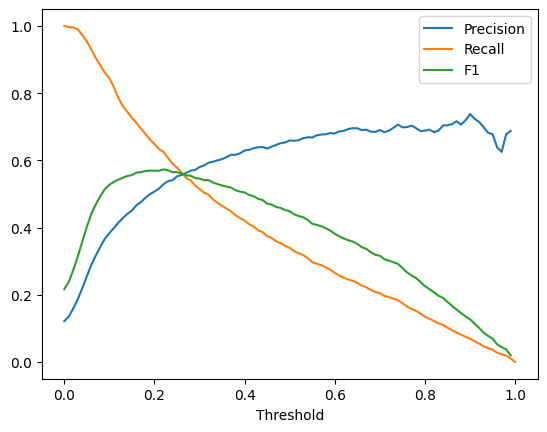

In [38]:
plt.plot(df_scores.t, df_scores.Precision, label='Precision')
plt.plot(df_scores.t, df_scores.Recall, label='Recall')
plt.plot(df_scores.t, df_scores.F1, label='F1')
plt.xlabel('Threshold')
plt.legend()
plt.show()

In [39]:
# Encontrar el valor máximo de F1
max_f1 = df_scores['F1'].max()

# Encontrar el índice donde ocurre este valor máximo
max_f1_idx = df_scores['F1'].idxmax()

# Obtener el valor correspondiente a t
t_max = df_scores['t'].iloc[max_f1_idx]

print(f" El valor máximo de F1 es {max_f1}, cuando t = {t_max}")

 El valor máximo de F1 es 0.5728642108000347, cuando t = 0.22


# Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

* 0.0001
* 0.006
* 0.06
* 0.26

In [40]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000, solver='liblinear')
    model.fit(X_train, y_train)
    
    return dv, model

In [41]:
dv, model = train(df_train, y_train)

In [42]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [43]:
y_pred = predict(df_val, dv, model)

In [44]:
n_splits = 5

for C in tqdm([1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/1 [00:00<?, ?it/s]

C=1 0.906 +- 0.006


# Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.000001, 0.001, 1]
* Initialize KFold with the same parameters as previously
* Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

* 0.000001
* 0.001
* 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [45]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.701 +- 0.009
C=0.001 0.861 +- 0.007
C=1 0.906 +- 0.006
